In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [2]:
class DCGAN():
    def __init__(self, W1_depth, W2_depth, filter_dim, batch_size, epochs, logdir, bias=True, batchnorm=False):
        self.W1_depth = W1_depth
        self.W2_depth = W2_depth
        self.filter_dim = filter_dim
        self.batch_size = batch_size
        self.epochs = epochs
        self.bias = bias
        self.batchnorm = batchnorm
        self.logdir = logdir
        self.learning_rate = 0.001
        
        with tf.variable_scope('discriminator'):
            self.D_W1 = tf.Variable(tf.random_normal([filter_dim, filter_dim, 1, W1_depth], mean=0, stddev=0.02))
            self.D_b1 = tf.Variable(tf.zeros([14, 14, 16]))
            self.D_W2 = tf.Variable(tf.random_normal([filter_dim, filter_dim, W1_depth, W2_depth], mean=0, stddev=0.02))
            self.D_b2 = tf.Variable(tf.zeros([7, 7, 64]))
            self.D_W3 = tf.Variable(tf.random_normal([7*7*64, 1], mean=0, stddev=0.02))
            self.D_b3 = tf.Variable(tf.zeros([1]))
    
        with tf.variable_scope('generator'):
            self.G_W1 = tf.Variable(tf.random_normal([100, 7*7*64], mean=0, stddev=0.02))
            self.G_b1 = tf.Variable(tf.zeros([7*7*64]))
            self.G_W2 = tf.Variable(tf.random_normal([filter_dim, filter_dim, W1_depth, W2_depth], mean=0, stddev=0.02))
            self.G_b2 = tf.Variable(tf.zeros([14, 14, 16]))
            self.G_W3 = tf.Variable(tf.random_normal([filter_dim, filter_dim, 1, W1_depth], mean=0, stddev=0.02))
            self.G_b3 = tf.Variable(tf.zeros([28, 28, 1]))
            
    def build_model(self):
        self.X = tf.placeholder(tf.float32, [None, 784], name='X')
        self.Z = tf.placeholder(tf.float32, [None, 100], name='Z')
        
        self.D_real = self.discriminator(self.X)
        self.fakes = self.generator(self.Z)
        self.D_fakes = self.discriminator(self.fakes)

        self.D_loss = -tf.reduce_mean(tf.log(self.D_real) + tf.log(1 - self.D_fakes))
        self.G_loss = -tf.reduce_mean(tf.log(self.D_fakes))
        
        self.D_train = tf.train.AdamOptimizer(self.learning_rate).minimize(self.D_loss, var_list=[self.D_W1, self.D_W2, self.D_W3,
                                                                                   self.D_b1, self.D_b2, self.D_b3])
        self.G_train = tf.train.AdamOptimizer(self.learning_rate).minimize(self.G_loss, var_list=[self.G_W1, self.G_W2, self.G_W3,
                                                                                   self.G_b1, self.G_b2, self.G_b3])
        
        self.summary_D_W1 = tf.summary.histogram('D_W1', self.D_W1)
        self.summary_D_b1 = tf.summary.histogram('D_b1', self.D_b1)
        self.summary_D_W2 = tf.summary.histogram('D_W2', self.D_W2)
        self.summary_D_b2 = tf.summary.histogram('D_b2', self.D_b2)
        self.summary_D_W3 = tf.summary.histogram('D_W3', self.D_W3)
        self.summary_D_b3 = tf.summary.histogram('D_b3', self.D_b3)
        self.summary_G_W1 = tf.summary.histogram('G_W1', self.G_W1)
        self.summary_G_b1 = tf.summary.histogram('G_b1', self.G_b1)
        self.summary_G_W2 = tf.summary.histogram('G_W2', self.G_W2)
        self.summary_G_b2 = tf.summary.histogram('G_b2', self.G_b2)
        self.summary_G_W3 = tf.summary.histogram('G_W3', self.G_W3)
        self.summary_G_b3 = tf.summary.histogram('G_b3', self.G_b3)
        
        self.summary_D_loss = tf.summary.scalar('D_loss', self.D_loss)
        self.summary_G_loss = tf.summary.scalar('G_loss', self.G_loss)
        
    def discriminator(self, x):
        x_4d = tf.reshape(x, [-1, 28, 28, 1])
        D_h1 = tf.nn.conv2d(x_4d, self.D_W1, strides=[1, 2, 2, 1], padding='SAME')
        if self.bias:
            D_h1 = tf.add(D_h1, self.D_b1)
        D_h1 = lrelu(D_h1)
        D_h2 = tf.nn.conv2d(D_h1, self.D_W2, strides=[1, 2, 2, 1], padding='SAME')        
        if self.bias:
            D_h2 = tf.add(D_h2, self.D_b2)    
        D_h2 = lrelu(D_h2)
        if self.batchnorm:
            D_h2 = batchnormalize(D_h2)
        D_h2_flat = tf.reshape(D_h2, [-1, 7*7*64])
        D_h3 = tf.matmul(D_h2_flat, self.D_W3)        
        if self.bias:
            D_h3 = tf.add(D_h3, self.D_b3)    
        D_h3 = tf.nn.sigmoid(D_h3)
        #if self.batchnorm:
        #    D_h3 = batchnormalize(D_h3)
        return D_h3

    def generator(self, z):
        G_h1 = tf.matmul(z, self.G_W1)        
        if self.bias:
            G_h1 = tf.add(G_h1, self.G_b1)
        G_h1 = tf.nn.relu(G_h1)
        if self.batchnorm:
            G_h1 = batchnormalize(G_h1)
        G_h1_square = tf.reshape(G_h1, [-1, 7, 7, 64])
        G_h2 = tf.nn.conv2d_transpose(G_h1_square, self.G_W2, output_shape=[100, 14, 14, 16], 
                                      strides=[1, 2, 2, 1], padding='SAME')        
        if self.bias:
            G_h2 = tf.add(G_h2, self.G_b2)
        G_h2 = tf.nn.relu(G_h2)
        if self.batchnorm:
            G_h2 = batchnormalize(G_h2)
        G_h3 = tf.nn.conv2d_transpose(G_h2, self.G_W3, output_shape=[100, 28, 28, 1],
                                      strides=[1, 2, 2, 1], padding='SAME')
        if self.bias:
            G_h3 = tf.add(G_h3, self.G_b3)
        G_h3 = tf.nn.sigmoid(G_h3)
        return G_h3
    
    def train_model(self):
        sess = tf.InteractiveSession()

        D_merged = tf.summary.merge([self.summary_D_W1, self.summary_D_W2, self.summary_D_W3, self.summary_D_b1,
                                     self.summary_D_b2, self.summary_D_b3, self.summary_D_loss])
        G_merged = tf.summary.merge([self.summary_G_W1, self.summary_G_W2, self.summary_G_W3, self.summary_G_b1,
                                     self.summary_G_b2, self.summary_G_b3, self.summary_G_loss])
        writer = tf.summary.FileWriter(self.logdir, sess.graph)

        sess.run(tf.global_variables_initializer())

        for i in range(mnist.train.num_examples * self.epochs // self.batch_size):
            batch = mnist.train.next_batch(self.batch_size)
            samples = sample(self.batch_size, 100)
            _, Dloss, D_summaries = sess.run([self.D_train, self.D_loss, D_merged], feed_dict={self.X: batch[0], self.Z: samples})
            _, Gloss, imgs, G_summaries = sess.run([self.G_train, self.G_loss, self.fakes, G_merged], feed_dict={self.Z: samples})

            if i % 10 == 0:
                writer.add_summary(D_summaries, i)
                writer.add_summary(G_summaries, i)

            if i % 2000 == 0:
                print('batch', i)
                print('D loss:', Dloss)
                print('G loss:', Gloss)
                fig, ax = plt.subplots(10, 10, figsize=(10,10))
                fig.subplots_adjust(hspace=0, wspace=0)
                for j in range(100):
                    ax[j//10][j%10].imshow(np.reshape(imgs[j, :], [28, 28]), cmap='gray')
                plt.show()

        writer.close()
    
def sample(m, n):
    return np.random.uniform(-1, 1, size=[m, n])
    
def lrelu(X, leak=0.2):
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * X + f2 * tf.abs(X)

def batchnormalize(X, eps=1e-8, g=None, b=None):
    if X.get_shape().ndims == 4:
        mean = tf.reduce_mean(X, [0,1,2])
        std = tf.reduce_mean( tf.square(X-mean), [0,1,2] )
        X = (X-mean) / tf.sqrt(std+eps)

        if g is not None and b is not None:
            g = tf.reshape(g, [1,1,1,-1])
            b = tf.reshape(b, [1,1,1,-1])
            X = X*g + b

    elif X.get_shape().ndims == 2:
        mean = tf.reduce_mean(X, 0)
        std = tf.reduce_mean(tf.square(X-mean), 0)
        X = (X-mean) / tf.sqrt(std+eps)

        if g is not None and b is not None:
            g = tf.reshape(g, [1,-1])
            b = tf.reshape(b, [1,-1])
            X = X*g + b

    else:
        raise NotImplementedError

    return X

batch 0
D loss: 1.38311
G loss: 0.726608


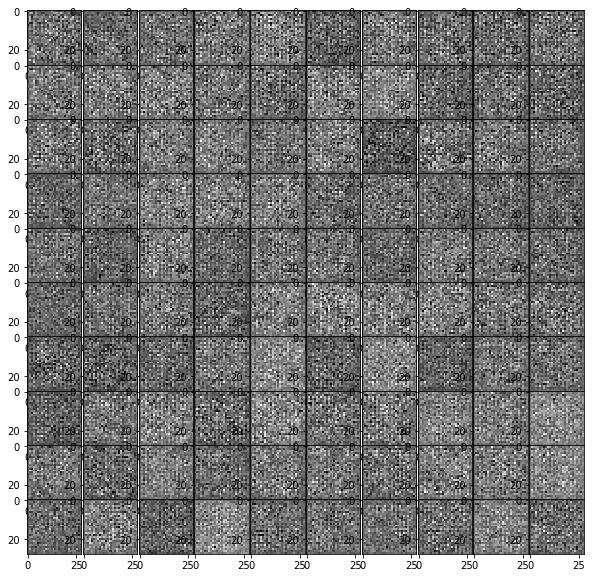

batch 2000
D loss: 0.25273
G loss: 3.94783


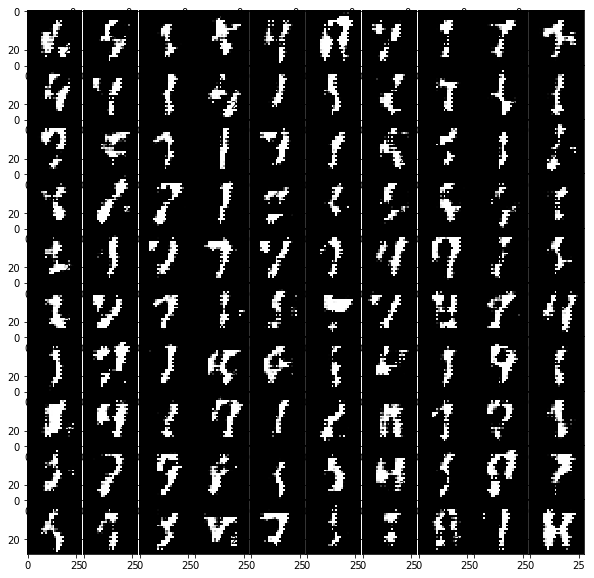

batch 4000
D loss: 0.614512
G loss: 1.82298


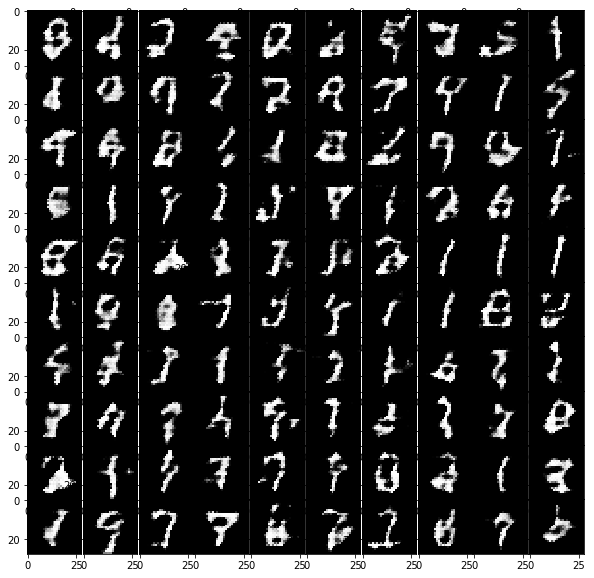

batch 6000
D loss: 0.88223
G loss: 1.6136


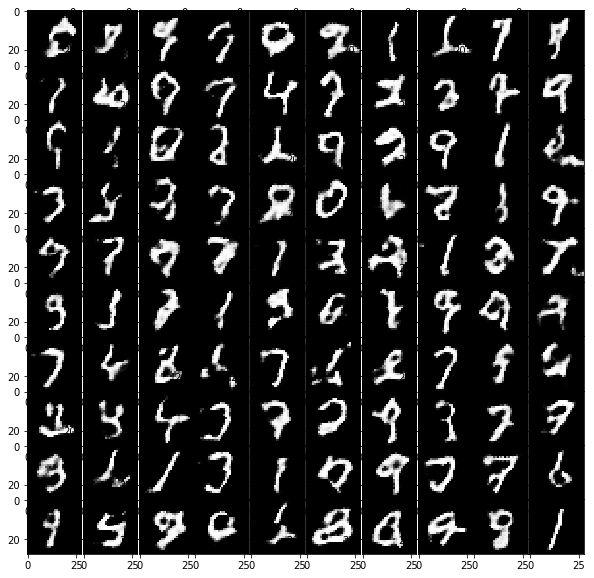

batch 8000
D loss: 0.933274
G loss: 1.73386


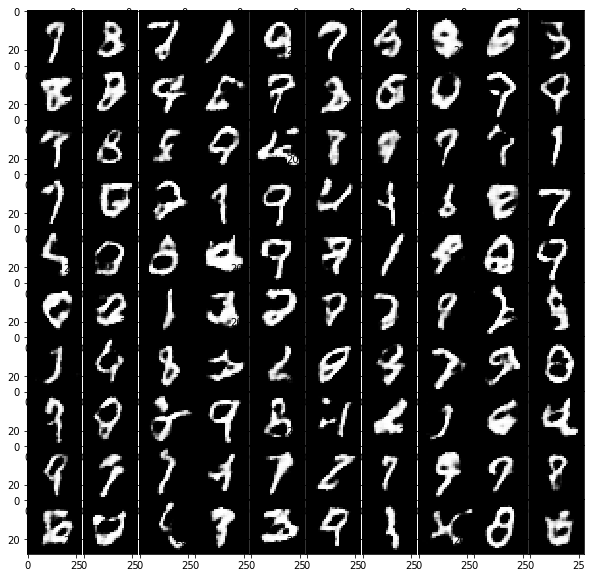

batch 10000
D loss: 0.824522
G loss: 1.61606


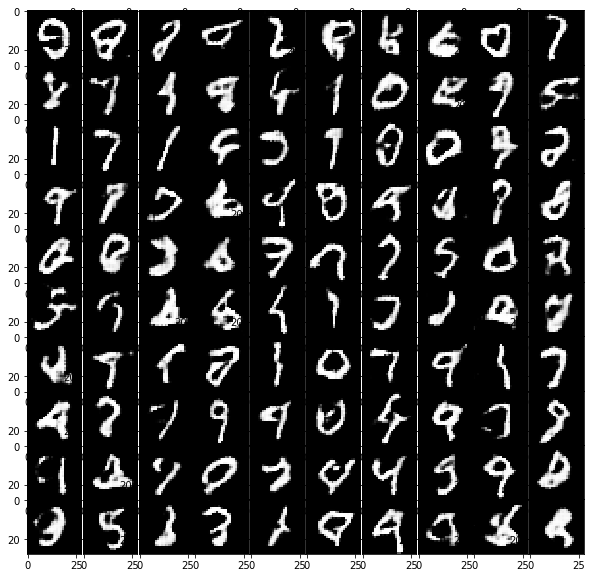

batch 12000
D loss: 0.983496
G loss: 1.60074


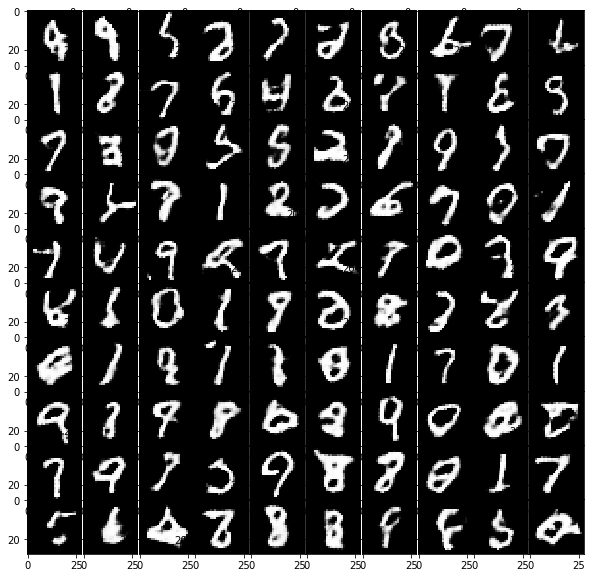

batch 14000
D loss: 0.857351
G loss: 1.59001


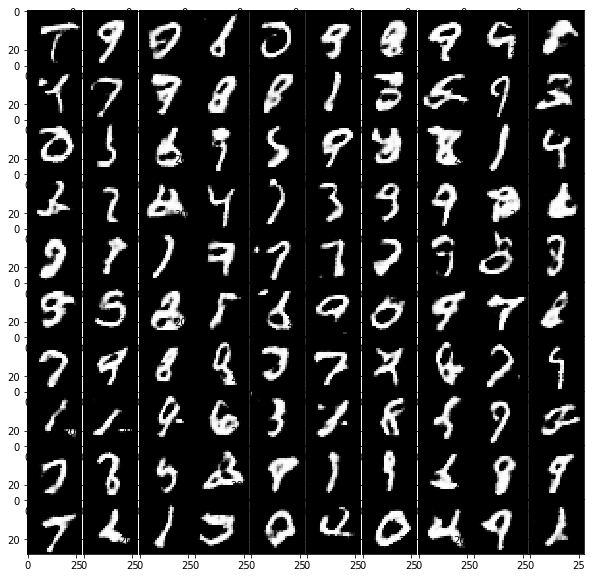

batch 16000
D loss: 1.01702
G loss: 1.33949


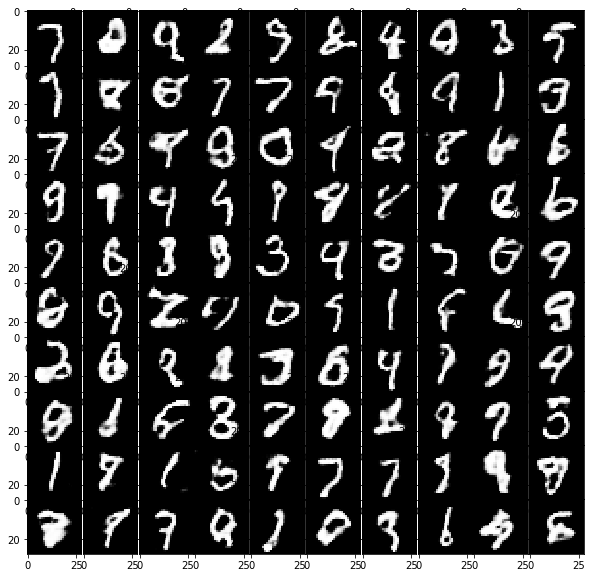

batch 18000
D loss: 1.05623
G loss: 1.53214


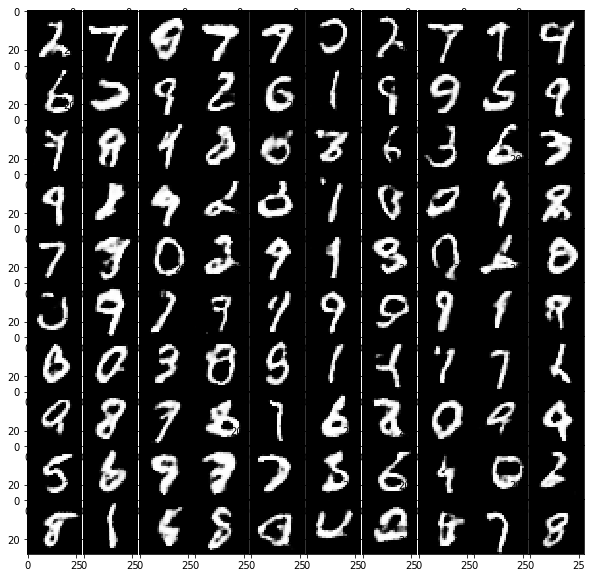

batch 20000
D loss: 0.952477
G loss: 1.69303


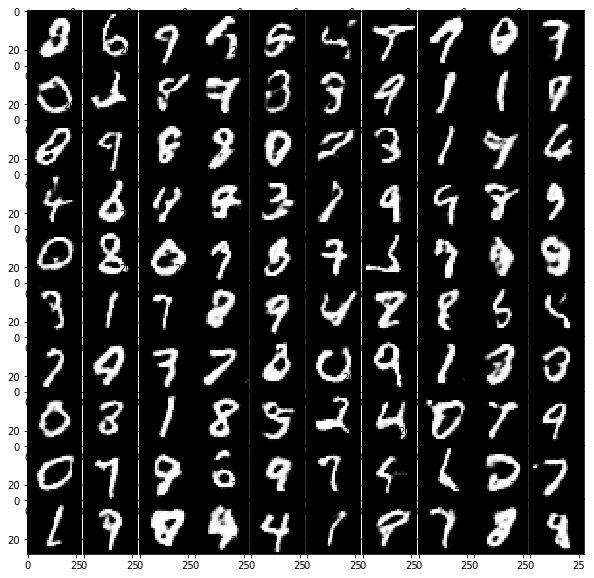

batch 22000
D loss: 0.930379
G loss: 1.81292


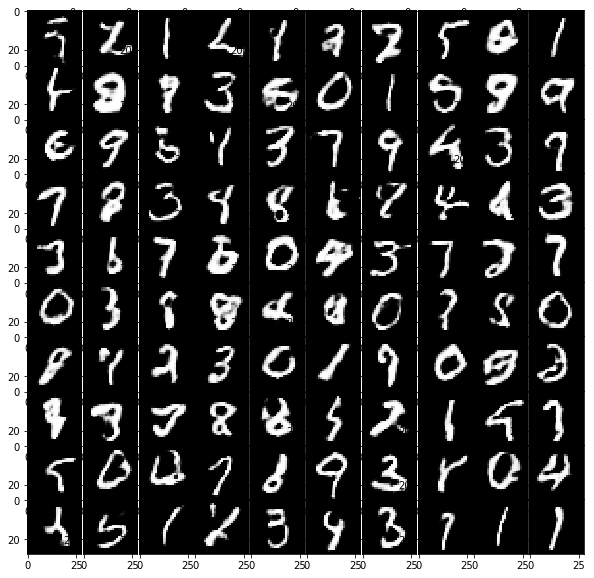

batch 24000
D loss: 0.727012
G loss: 1.57542


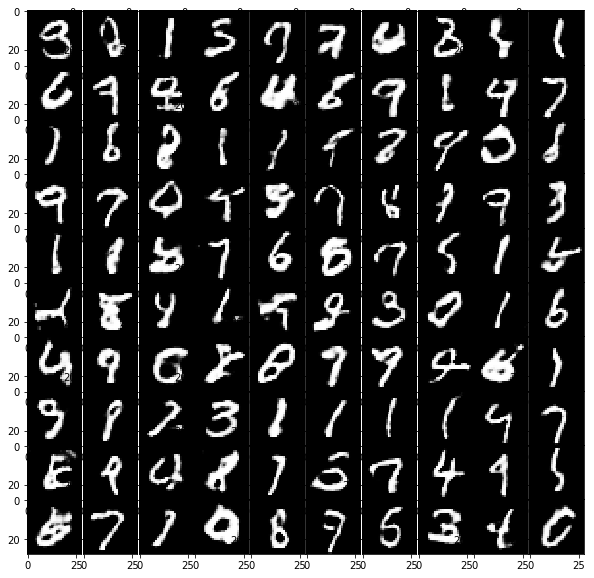

batch 26000
D loss: 0.864079
G loss: 1.69044


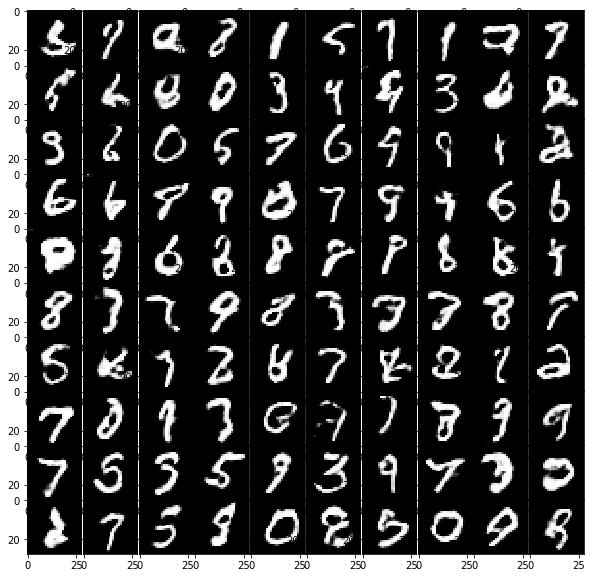

In [52]:
gan = DCGAN(16, 64, 4, 100, 50, 'logs/dcgan/bias_nobatch_filter4', bias=True, batchnorm=False)
gan.build_model()
gan.train_model()

batch 0
D loss: 1.3783
G loss: 0.765462


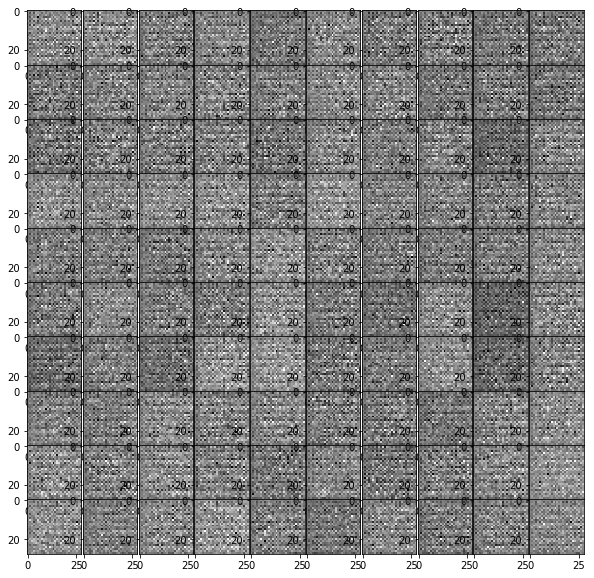

batch 2000
D loss: 0.629055
G loss: 2.7746


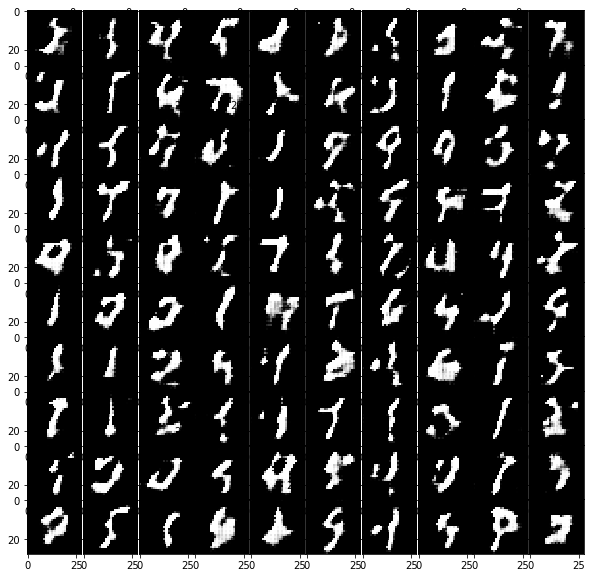

batch 4000
D loss: 1.03866
G loss: 2.28584


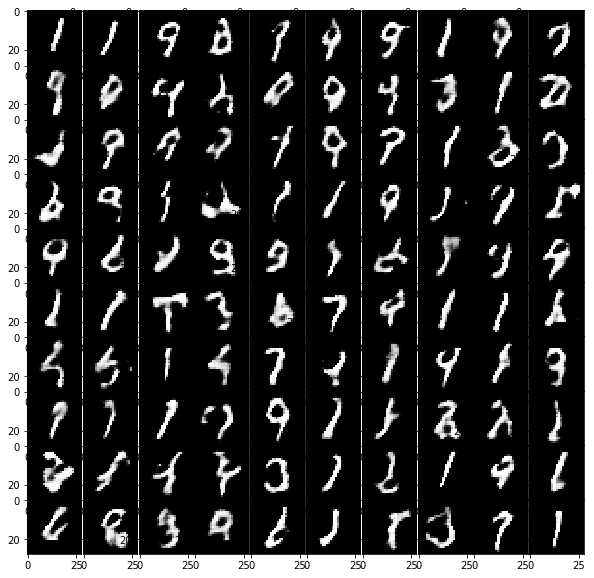

batch 6000
D loss: 1.30348
G loss: 1.58335


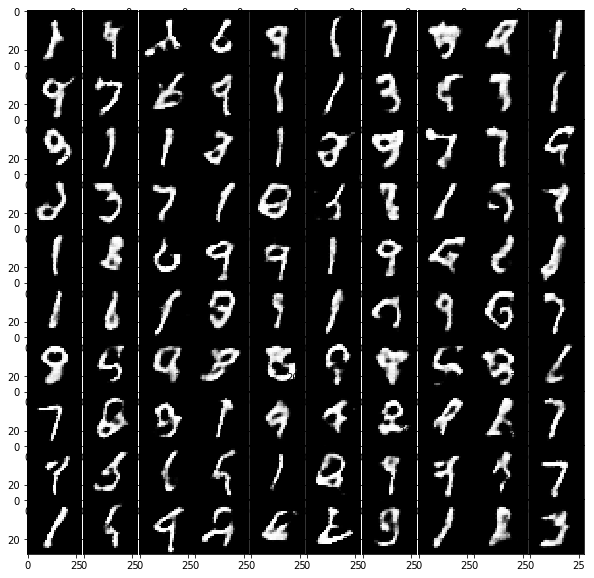

batch 8000
D loss: 1.02318
G loss: 1.87172


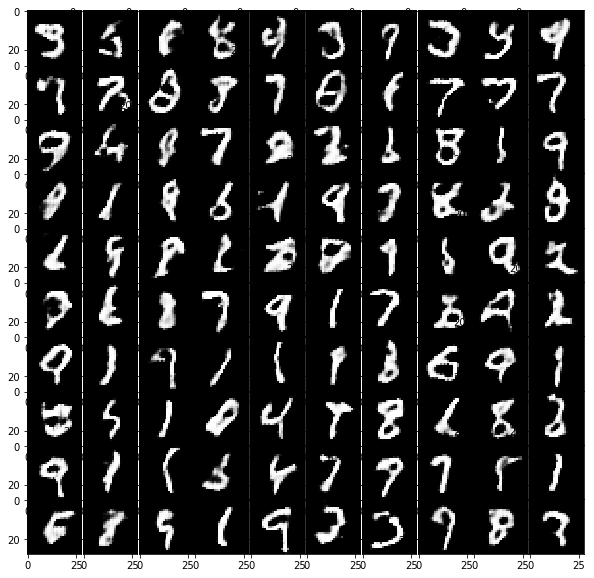

batch 10000
D loss: 0.660486
G loss: 1.91985


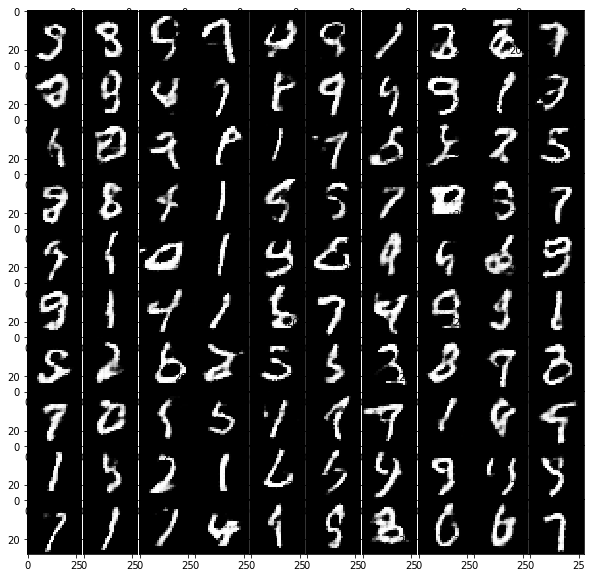

batch 12000
D loss: 0.846549
G loss: 1.66616


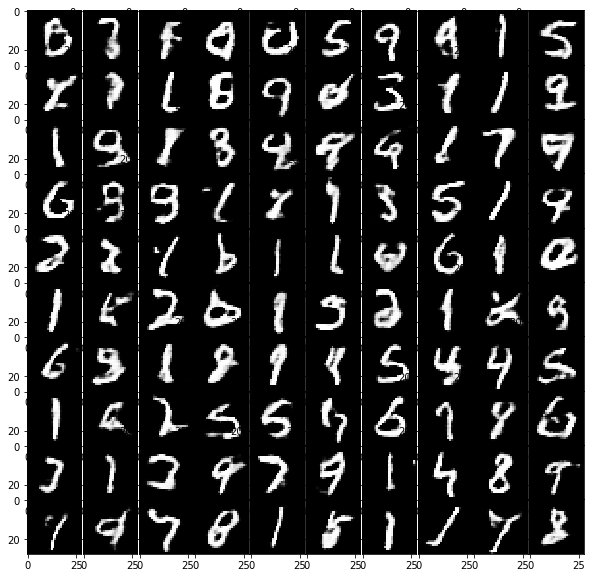

batch 14000
D loss: 1.004
G loss: 1.83878


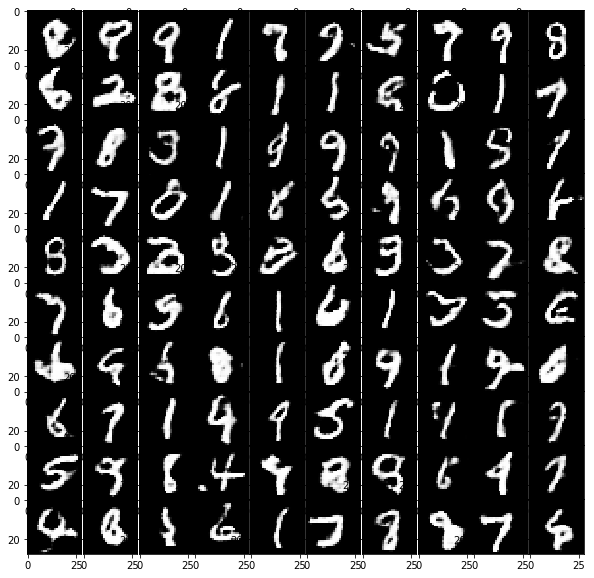

batch 16000
D loss: 0.79538
G loss: 1.61202


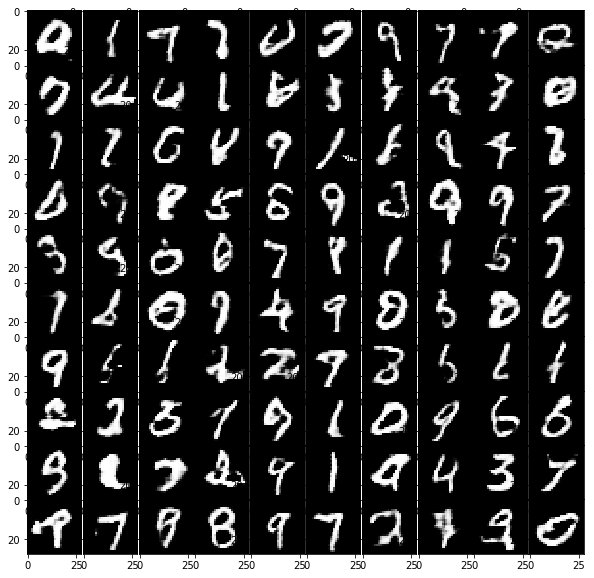

batch 18000
D loss: 0.888873
G loss: 1.5897


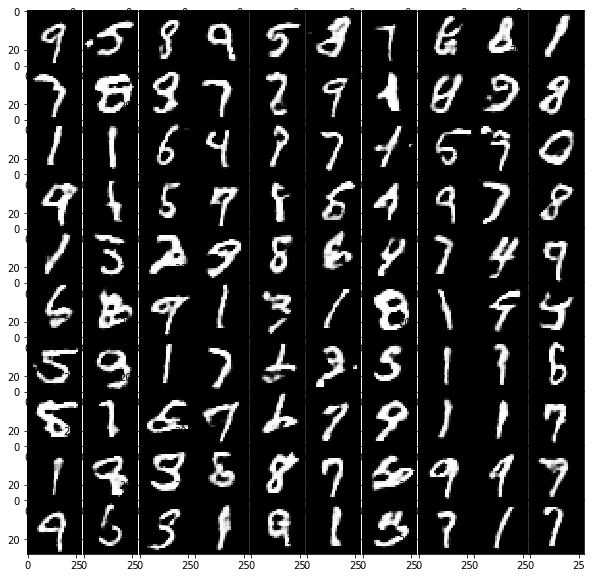

batch 20000
D loss: 1.20478
G loss: 1.79915


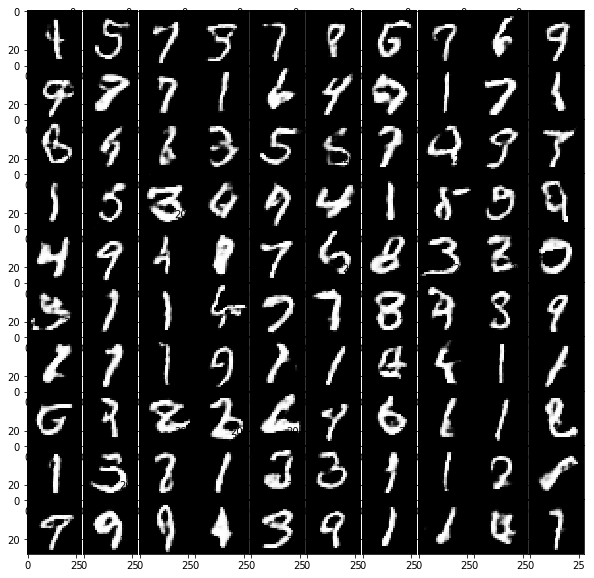

batch 22000
D loss: 1.05628
G loss: 1.81015


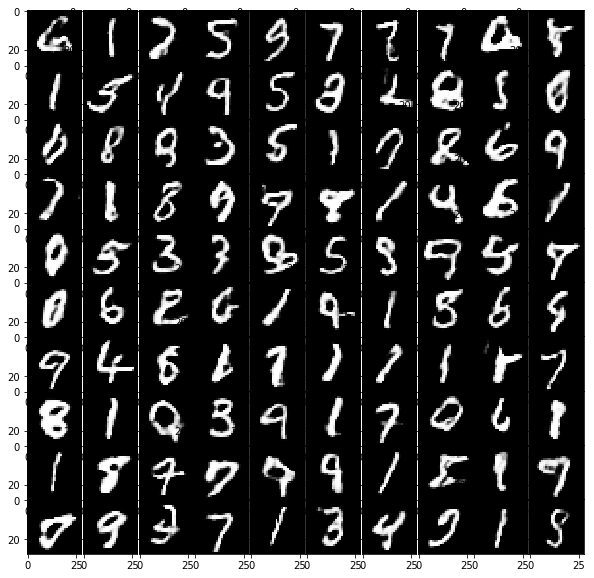

batch 24000
D loss: 0.781631
G loss: 1.48885


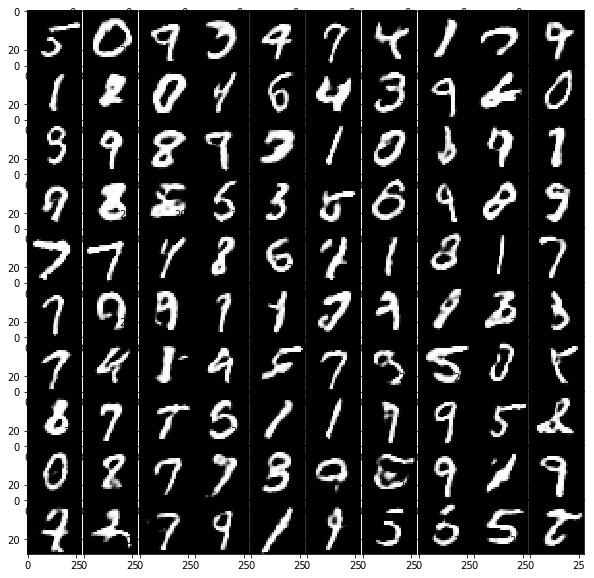

batch 26000
D loss: 0.998299
G loss: 1.57507


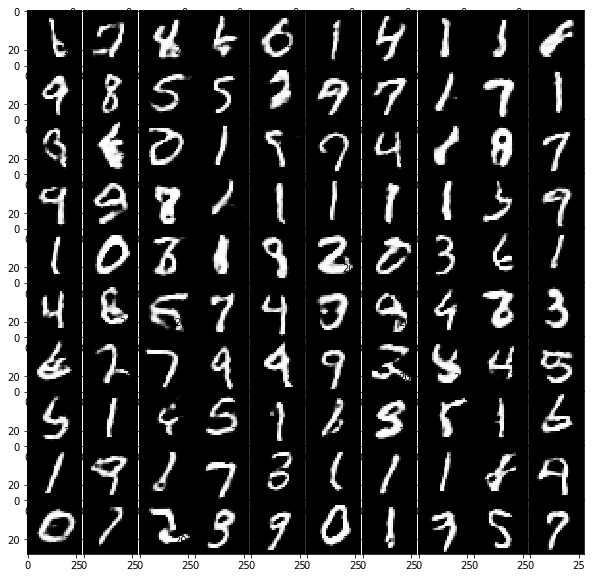

In [3]:
gan = DCGAN(16, 64, 5, 100, 50, 'logs/dcgan/bias_nobatch_filter5', bias=True, batchnorm=False)
gan.build_model()
gan.train_model()

batch 0
D loss: 1.38244
G loss: 0.779837


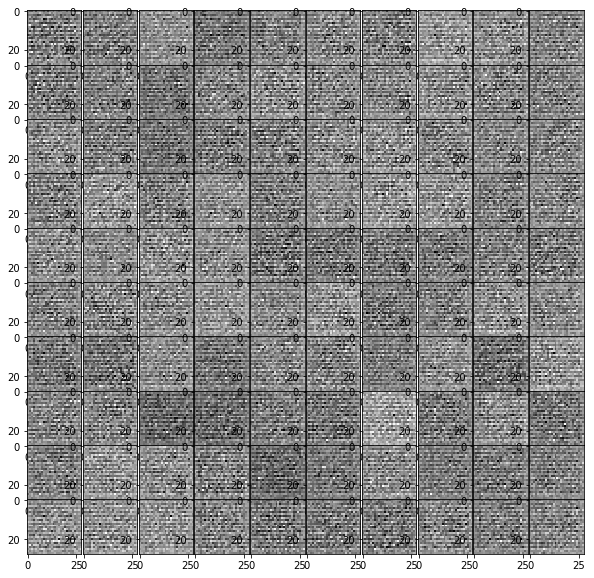

batch 2000
D loss: 0.432989
G loss: 2.9875


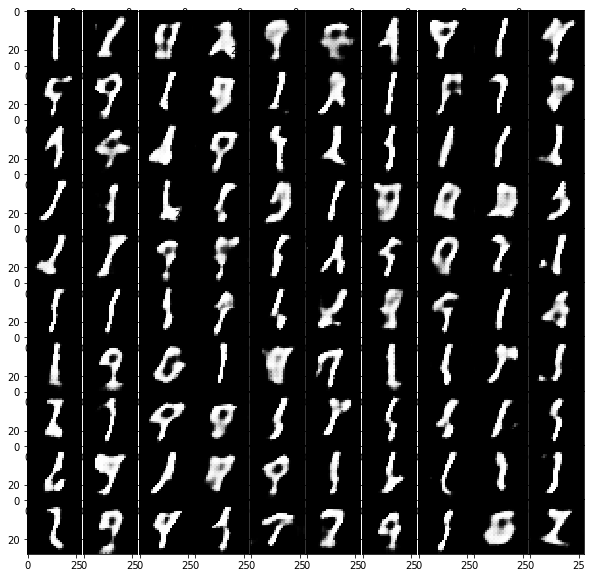

batch 4000
D loss: 0.468068
G loss: 2.4433


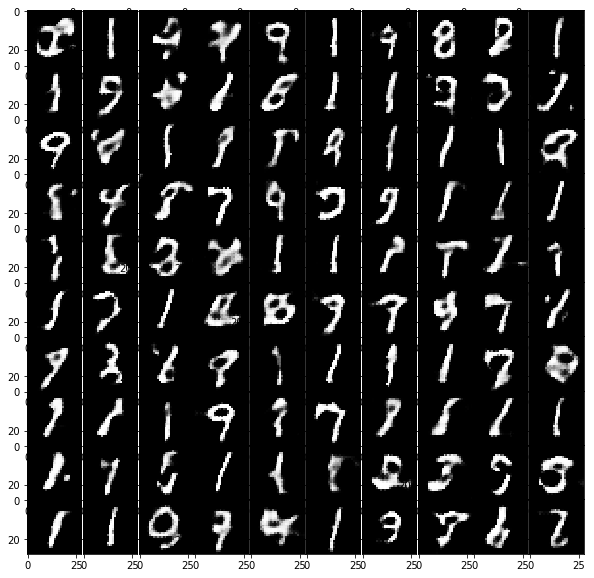

batch 6000
D loss: 0.539139
G loss: 1.96828


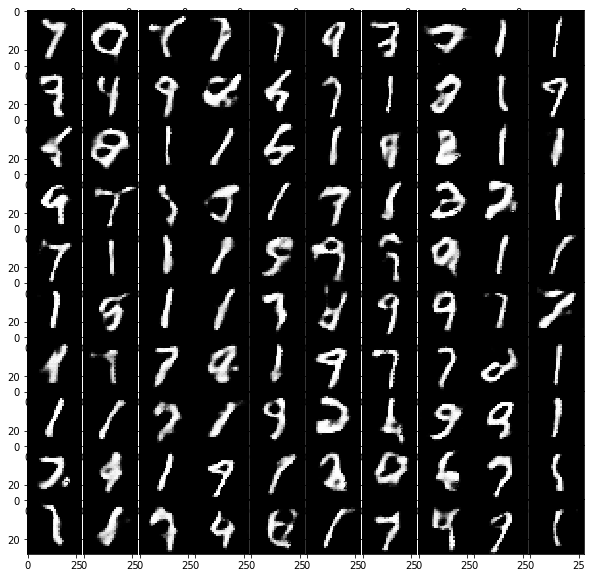

batch 8000
D loss: 0.791866
G loss: 2.18676


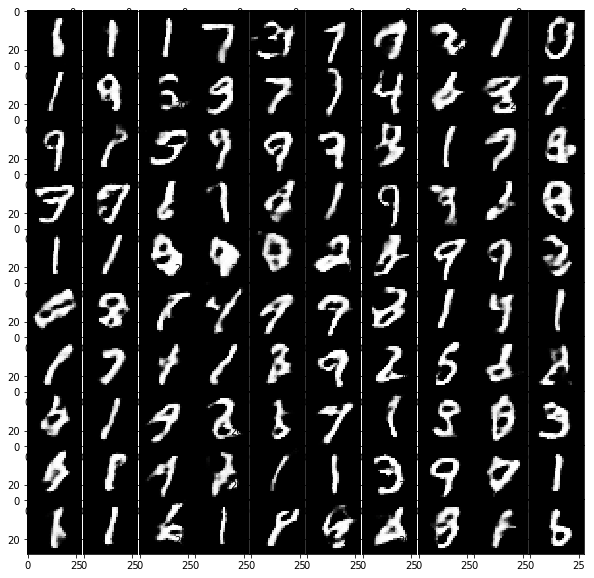

batch 10000
D loss: 0.901064
G loss: 1.73124


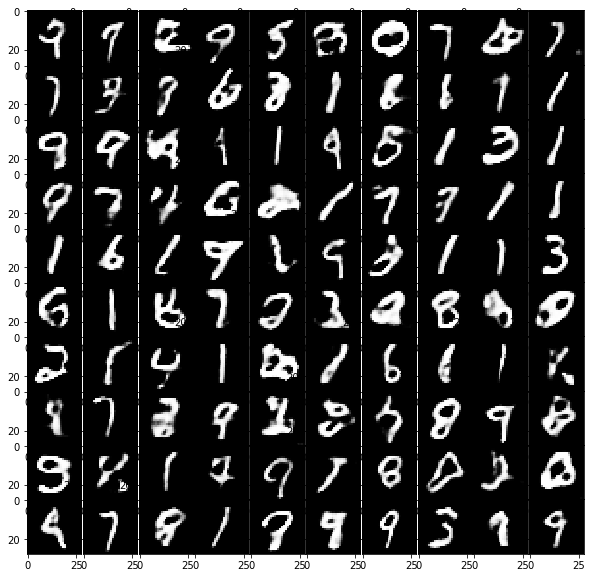

batch 12000
D loss: 0.864811
G loss: 2.27094


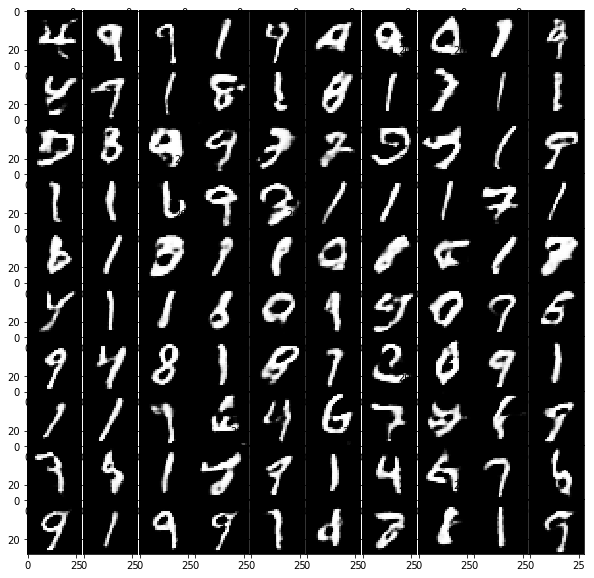

batch 14000
D loss: 0.748774
G loss: 1.83219


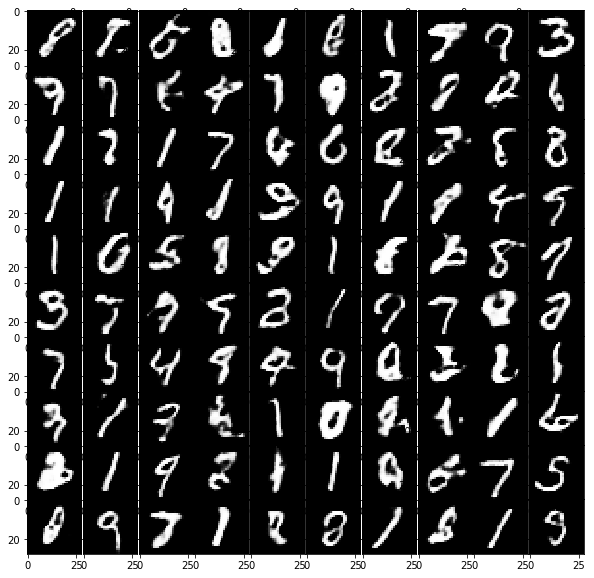

batch 16000
D loss: 0.981505
G loss: 2.23373


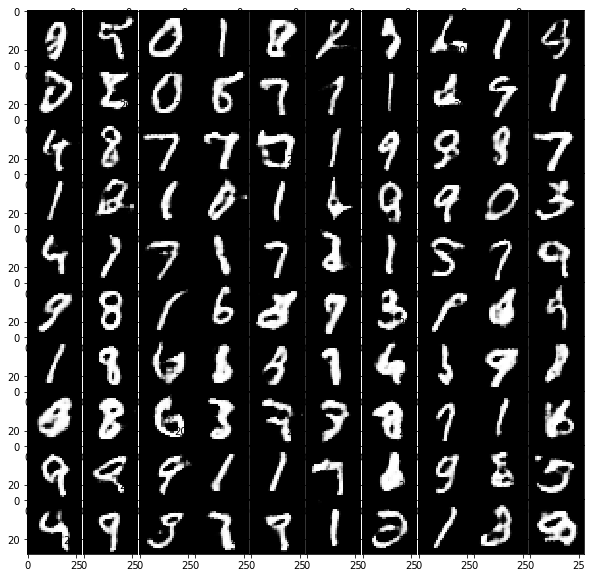

batch 18000
D loss: 0.734818
G loss: 1.88407


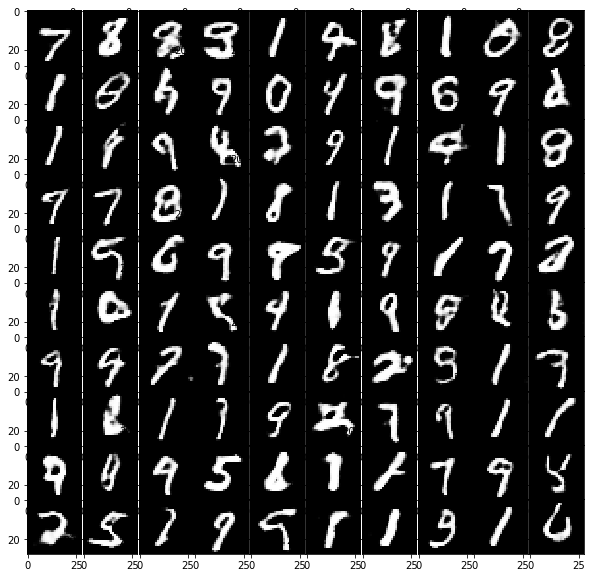

batch 20000
D loss: 0.879598
G loss: 1.46287


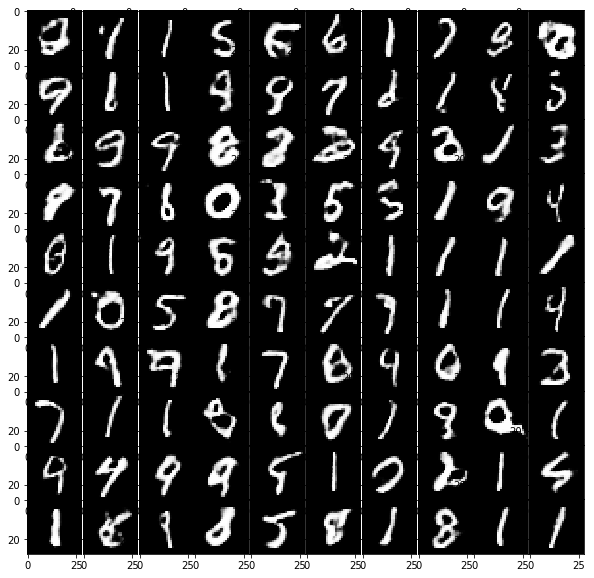

batch 22000
D loss: 0.669049
G loss: 2.13042


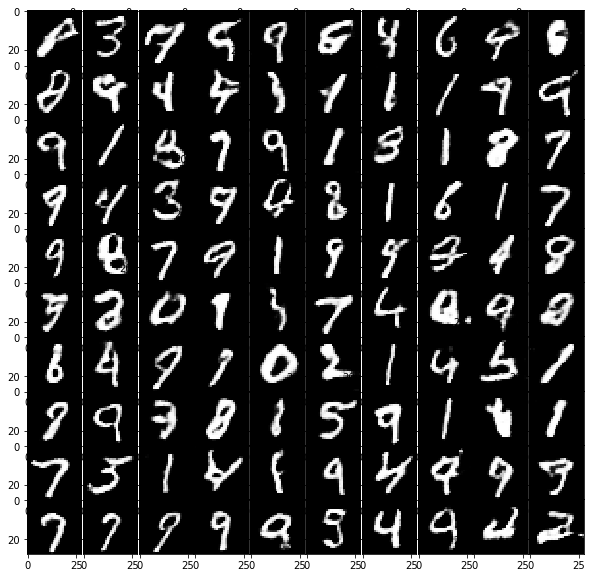

batch 24000
D loss: 1.04413
G loss: 1.28698


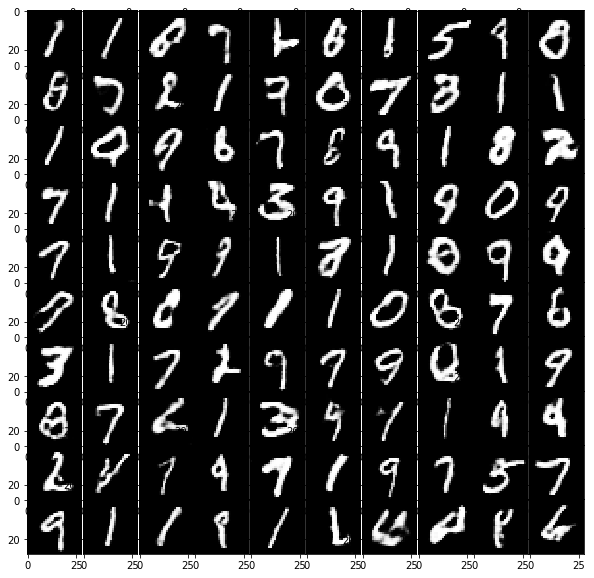

batch 26000
D loss: 0.804437
G loss: 1.86382


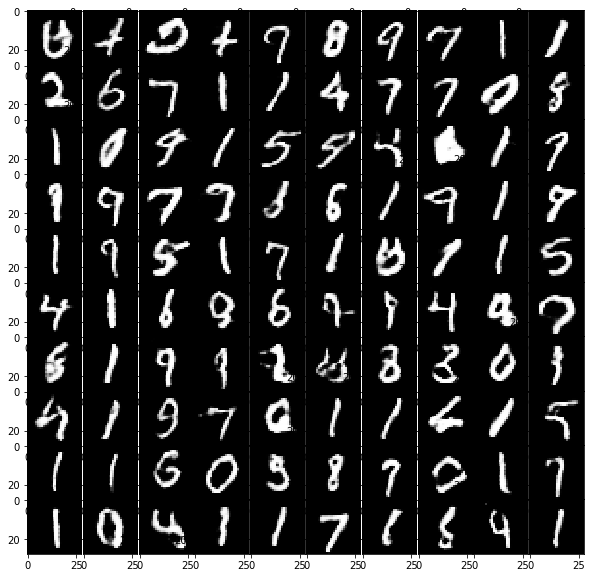

In [4]:
gan = DCGAN(16, 64, 6, 100, 50, 'logs/dcgan/bias_nobatch_filter6', bias=True, batchnorm=False)
gan.build_model()
gan.train_model()

batch 0
D loss: 0.742837
G loss: 5.65042


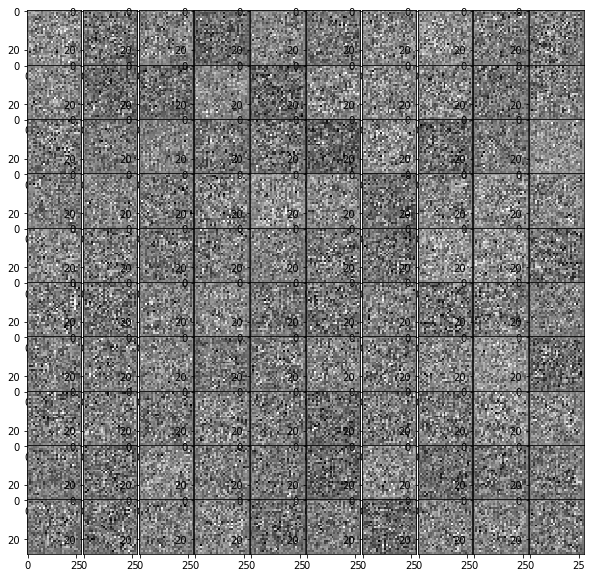

InvalidArgumentError: Nan in summary histogram for: D_W1_5
	 [[Node: D_W1_5 = HistogramSummary[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](D_W1_5/tag, discriminator_5/Variable/read)]]

Caused by op 'D_W1_5', defined at:
  File "C:\Users\Brendan\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Brendan\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Brendan\Anaconda3\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Users\Brendan\Anaconda3\lib\site-packages\traitlets\config\application.py", line 596, in launch_instance
    app.start()
  File "C:\Users\Brendan\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\Brendan\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\Brendan\Anaconda3\lib\site-packages\tornado\ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "C:\Users\Brendan\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Brendan\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\Brendan\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\Brendan\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\Brendan\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Brendan\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\Brendan\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\Brendan\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\Brendan\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Brendan\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Brendan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Brendan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\Brendan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-a6613d56a5ad>", line 2, in <module>
    gan.build_model()
  File "<ipython-input-10-dfa58abb1290>", line 45, in build_model
    self.summary_D_W1 = tf.summary.histogram('D_W1', self.D_W1)
  File "C:\Users\Brendan\Anaconda3\lib\site-packages\tensorflow\python\summary\summary.py", line 207, in histogram
    tag=scope.rstrip('/'), values=values, name=scope)
  File "C:\Users\Brendan\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_logging_ops.py", line 139, in _histogram_summary
    name=name)
  File "C:\Users\Brendan\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "C:\Users\Brendan\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\Brendan\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Nan in summary histogram for: D_W1_5
	 [[Node: D_W1_5 = HistogramSummary[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](D_W1_5/tag, discriminator_5/Variable/read)]]


In [11]:
gan = DCGAN(16, 64, 4, 100, 50, 'logs/dcgan/nobias_batch_filter4', bias=False, batchnorm=True)
gan.build_model()
gan.train_model()